In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

# Set environment variable for memory optimization
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Competition-specific settings
FORECAST_HORIZON = 10
LOOK_BACK = 90
BATCH_SIZE = 512
EPOCHS = 15
NUM_ENSEMBLE = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        attn_scores = self.attn(x)
        max_scores = torch.max(attn_scores, dim=1, keepdim=True)[0]
        attn_scores = attn_scores - max_scores
        attn_weights = self.softmax(attn_scores)
        context = torch.sum(attn_weights * x, dim=1)
        return context

class LSTMModelWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, dropout_rate=0.3):
        super(LSTMModelWithAttention, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.attention = Attention(hidden_size2)
        self.fc1 = nn.Linear(hidden_size2, 16)
        self.fc2 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        for layer in [self.lstm1, self.lstm2, self.fc1, self.fc2]:
            if hasattr(layer, 'weight'):
                nn.init.xavier_uniform_(layer.weight)
        nn.init.xavier_uniform_(self.attention.attn.weight)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = self.attention(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.alpha = alpha

    def forward(self, outputs, targets):
        mse_loss = self.mse(outputs, targets)
        mae_loss = torch.mean(torch.abs(targets - outputs))
        return self.alpha * mse_loss + (1 - self.alpha) * mae_loss

def load_data():
    train = pd.read_csv('train/ETH.csv')
    test = pd.read_csv('test/ETH.csv')
    print("Train columns:", train.columns.tolist())
    print("Test columns:", test.columns.tolist())
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    train['timestamp_int'] = (train['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ns')
    test['timestamp_int'] = (test['timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1ns')
    agg_dict = {'timestamp': 'first'}
    agg_dict.update({col: 'mean' for col in train.columns if col not in ['timestamp', 'timestamp_int']})
    # train = train.groupby('timestamp_int').agg(agg_dict).reset_index()
    # test = test.groupby('timestamp_int').agg(agg_dict).reset_index()
    train.set_index('timestamp_int', inplace=True)
    test.set_index('timestamp_int', inplace=True)
    train = train.sort_index()
    test = test.sort_index()
    print(f"Train dataset size: {len(train)} rows")
    print("Train columns after load_data:", train.columns.tolist())
    return train, test

def calculate_rsi(data, periods=14):
    delta = data['mid_price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / (loss + 1e-6)
    return 100 - (100 / (1 + rs))

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['mid_price'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['mid_price'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def engineer_features(df, look_back=LOOK_BACK):
    df = df.copy()
    book_levels = 5
    bid_price_cols = [f'bid_price{i}' for i in range(1, book_levels+1)]
    bid_volume_cols = [f'bid_volume{i}' for i in range(1, book_levels+1)]
    ask_price_cols = [f'ask_price{i}' for i in range(1, book_levels+1)]
    ask_volume_cols = [f'ask_volume{i}' for i in range(1, book_levels+1)]
    df = df.interpolate(method='linear').ffill().bfill()
    df = df.replace([np.inf, -np.inf], np.nan).interpolate(method='linear').ffill().bfill()
    print("NaN counts after filling:\n", df.isna().sum())
    print("Infinity counts after filling:\n", ((df == np.inf) | (df == -np.inf)).sum())
    if df.isna().any().any():
        print("Warning: NaN values remain after filling")
    if 'mid_price' not in df.columns:
        df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['mid_price'] = df['mid_price'].clip(lower=1e-6)
    df['spread'] = df['ask_price1'] - df['bid_price1']
    df['total_bid_volume'] = df[[col for col in bid_volume_cols if col in df.columns]].sum(axis=1)
    df['total_ask_volume'] = df[[col for col in ask_volume_cols if col in df.columns]].sum(axis=1)
    df['volume_imbalance'] = (df['total_bid_volume'] - df['total_ask_volume']) / (df['total_bid_volume'] + df['total_ask_volume'] + 1e-6)
    df['weighted_bid_price'] = np.average(df[[col for col in bid_price_cols if col in df.columns]],
                                          weights=df[[col for col in bid_volume_cols if col in df.columns]], axis=1)
    df['weighted_ask_price'] = np.average(df[[col for col in ask_price_cols if col in df.columns]],
                                          weights=df[[col for col in ask_volume_cols if col in df.columns]], axis=1)
    df['price_velocity'] = df['mid_price'].diff().fillna(0)
    df['volume_velocity'] = df['total_bid_volume'].diff().fillna(0)
    df['log_returns'] = np.log(df['mid_price'] / df['mid_price'].shift(1)).clip(lower=-10, upper=10)
    df['iv'] = df['log_returns'].rolling(window=60).std() * np.sqrt(365 * 24 * 3600)
    df['iv'] = df['iv'].replace([np.inf, -np.inf], np.nan).interpolate(method='linear').ffill().bfill()
    df['iv_ema'] = df['iv'].ewm(span=10).mean()
    for lag in [1, 5, 10]:
        df[f'iv_lag_{lag}'] = df['iv'].shift(lag).bfill()
        df[f'price_velocity_lag_{lag}'] = df['price_velocity'].shift(lag).bfill()
        df[f'volume_imbalance_lag_{lag}'] = df['volume_imbalance'].shift(lag).bfill()
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['rsi'] = calculate_rsi(df).bfill()
    df['macd'], df['macd_signal'] = calculate_macd(df)
    df['macd'] = df['macd'].bfill()
    df['macd_signal'] = df['macd_signal'].bfill()
    for i in range(2, 6):
        if f'bid_volume{i}' in df.columns and f'ask_volume{i}' in df.columns:
            df[f'bid_ask_ratio_{i}'] = df[f'bid_volume{i}'] / (df[f'ask_volume{i}'] + 1e-6)
            df[f'bid_ask_ratio_{i}'] = df[f'bid_ask_ratio_{i}'].clip(lower=-10, upper=10).bfill()
    print("Engineered columns:", df.columns.tolist())
    return df

def add_noise(data, noise_factor=0.01):
    stds = np.std(data, axis=0)
    stds = np.where(stds == 0, 1.0, stds)  # Prevent division by zero
    noise = np.random.normal(0, noise_factor * stds, data.shape)
    return data + noise

def prepare_data(df, feature_cols=None, target_col='iv', look_back=LOOK_BACK, forecast_horizon=FORECAST_HORIZON):
    if feature_cols is None:
        feature_cols = ['iv', 'mid_price', 'spread', 'volume_imbalance', 'price_velocity', 'iv_ema',
                        'hour', 'day_of_week', 'rsi', 'macd', 'macd_signal'] + \
                       [f'bid_ask_ratio_{i}' for i in range(2, 6)] + \
                       [f'iv_lag_{lag}' for lag in [1,5,10]] + \
                       [f'price_velocity_lag_{lag}' for lag in [1,5,10]] + \
                       [f'volume_imbalance_lag_{lag}' for lag in [1,5,10]]
    feature_cols = [col for col in feature_cols if col in df.columns]
    print("Selected feature columns:", feature_cols)
    scaler = RobustScaler()
    scaler.fit(df[feature_cols])
    scaler.scale_ = np.where(scaler.scale_ == 0, 1.0, scaler.scale_)
    scaled_data = scaler.transform(df[feature_cols])
    np.clip(scaled_data, -10, 10, out=scaled_data)
    if np.any(np.isnan(scaled_data)) or np.any(np.isinf(scaled_data)):
        print("Warning: NaN or Inf in scaled data")
        scaled_data = np.nan_to_num(scaled_data, nan=0.0, posinf=1e6, neginf=-1e6)
    scaled_data = add_noise(scaled_data, noise_factor=0.01)
    n_samples = len(df) - look_back - forecast_horizon + 1
    if n_samples <= 0:
        raise ValueError(f"Dataset too small for look_back={look_back} and forecast_horizon={forecast_horizon}")
    X = np.array([scaled_data[i:i + look_back] for i in range(n_samples)])
    y = scaled_data[look_back + forecast_horizon - 1 : n_samples + look_back + forecast_horizon - 1, feature_cols.index(target_col)]
    if np.any(np.isnan(X)) or np.any(np.isnan(y)):
        print("Warning: NaN values in X or y")
        X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
        y = np.nan_to_num(y, nan=0.0, posinf=1e6, neginf=-1e6)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)
    return X, y, scaler, feature_cols.index(target_col), feature_cols

def train_model(model, X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.3):
    criterion = CombinedLoss(alpha=0.5)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    train_size = int((1 - validation_split) * len(X))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5
    trigger_times = 0
    best_model_state = model.state_dict()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        processed_samples = 0
        with torch.cuda.amp.autocast():
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X)
                if torch.any(torch.isnan(outputs)) or torch.any(torch.isinf(outputs)):
                    print("Warning: NaN or Inf in model outputs")
                    continue
                loss = criterion(outputs, batch_y.unsqueeze(1))
                if torch.isnan(loss) or torch.isinf(loss):
                    print("Warning: NaN or Inf in loss")
                    continue
                loss.backward()
                for p in model.parameters():
                    if p.grad is not None:
                        p.grad.data = torch.nan_to_num(p.grad.data, nan=0.0)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item() * batch_X.size(0)
                processed_samples += batch_X.size(0)
        if processed_samples > 0:
            train_loss /= processed_samples
        else:
            train_loss = float('nan')
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        val_processed = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))
                if not torch.isnan(loss) and not torch.isinf(loss):
                    val_loss += loss.item() * batch_X.size(0)
                    val_processed += batch_X.size(0)
        if val_processed > 0:
            val_loss /= val_processed
        else:
            val_loss = float('nan')
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GiB")
        scheduler.step(val_loss)
        if not np.isnan(val_loss) and val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            trigger_times = 0
        else:
            trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            break
        torch.cuda.empty_cache()
    return train_losses, val_losses

def predict_test(models, test_data, scaler, feature_cols, look_back=LOOK_BACK, forecast_horizon=FORECAST_HORIZON, batch_size=128):
    # Ensure feature_cols matches train
    feature_cols = [col for col in feature_cols if col in test_data.columns]
    print("Test feature columns:", feature_cols)
    test_scaled = scaler.transform(test_data[feature_cols])
    print("test_scaled shape:", test_scaled.shape)
    if np.any(np.isnan(test_scaled)) or np.any(np.isinf(test_scaled)):
        print("Warning: NaN or Inf in test_scaled")
        test_scaled = np.nan_to_num(test_scaled, nan=0.0, posinf=1e6, neginf=-1e6)
    n_samples = len(test_data)
    test_sequences = []
    expected_shape = (look_back, len(feature_cols))
    for i in range(n_samples):
        start = max(0, i + look_back - n_samples)
        seq = test_scaled[start:i + look_back]
        if len(seq) < look_back:
            padded = np.zeros(expected_shape)
            padded[-len(seq):] = seq
            seq = padded
        if seq.shape != expected_shape:
            print(f"Warning: Sequence {i} has shape {seq.shape}, expected {expected_shape}")
            seq = seq[-look_back:] if seq.shape[0] > look_back else np.pad(seq, ((look_back - seq.shape[0], 0), (0, 0)), mode='constant')
        test_sequences.append(seq)
    try:
        test_sequences = np.array(test_sequences)
        print("test_sequences shape:", test_sequences.shape)
    except ValueError as e:
        print("Error converting test_sequences to array:", e)
        for i, seq in enumerate(test_sequences):
            print(f"Sequence {i} shape: {seq.shape}")
        raise
    test_tensor = torch.tensor(test_sequences, dtype=torch.float32).to(device)

    all_predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            model_predictions = []
            for i in range(0, len(test_tensor), batch_size):
                batch = test_tensor[i:i + batch_size]
                outputs = model(batch)
                model_predictions.append(outputs.cpu().numpy()[:, 0])
            model_predictions = np.concatenate(model_predictions, axis=0)
        all_predictions.append(model_predictions)

    test_predictions = np.mean(all_predictions, axis=0)

    remaining_steps = max(0, n_samples - len(test_sequences))
    if remaining_steps > 0:
        current_sequence = test_tensor[-1].unsqueeze(0)
        with torch.no_grad():
            for _ in range(remaining_steps):
                next_preds = []
                for model in models:
                    next_pred = model(current_sequence)
                    next_preds.append(next_pred.cpu().numpy()[0, 0])
                next_pred_avg = np.mean(next_preds)
                test_predictions = np.append(test_predictions, next_pred_avg)
                new_input = np.zeros((1, 1, len(feature_cols)))
                new_input[0, 0, feature_cols.index('iv')] = next_pred_avg
                new_input = torch.tensor(new_input, dtype=torch.float32).to(device)
                current_sequence = torch.cat((current_sequence[:, 1:, :], new_input), dim=1)

    test_predictions_full = np.zeros((len(test_predictions), len(feature_cols)))
    test_predictions_full[:, feature_cols.index('iv')] = test_predictions
    test_predictions = scaler.inverse_transform(test_predictions_full)[:, feature_cols.index('iv')]
    return test_predictions[:len(test_data)]

Using device: cuda


In [2]:
start_time = time.time()
train, test = load_data()
train = engineer_features(train)
test = engineer_features(test)

# Ensure feature_cols consistency
feature_cols = ['iv', 'mid_price', 'spread', 'volume_imbalance', 'price_velocity', 'iv_ema',
                'hour', 'day_of_week', 'rsi', 'macd', 'macd_signal'] + \
               [f'bid_ask_ratio_{i}' for i in range(2, 6)] + \
               [f'iv_lag_{lag}' for lag in [1,5,10]] + \
               [f'price_velocity_lag_{lag}' for lag in [1,5,10]] + \
               [f'volume_imbalance_lag_{lag}' for lag in [1,5,10]]
feature_cols = [col for col in feature_cols if col in train.columns and col in test.columns]
print("Final feature columns:", feature_cols)

# Check stationarity
# result = adfuller(train['iv'])
# print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")
# if result[1] > 0.05:
#     print("Warning: IV series is non-stationary; applying differencing")
#     train['iv'] = train['iv'].diff().fillna(0)
#     test['iv'] = test['iv'].diff().fillna(0)
#
# # Correlation for feature selection
# correlation_matrix = train.corr(numeric_only=True)['iv'].sort_values(ascending=False)
# print("Correlations with IV:\n", correlation_matrix)

Train columns: ['timestamp', 'mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5', 'ask_volume5', 'label']
Test columns: ['timestamp', 'mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_price4', 'ask_volume4', 'ask_price5', 'ask_volume5']
Train dataset size: 631292 rows
Train columns after load_data: ['timestamp', 'mid_price', 'bid_price1', 'bid_volume1', 'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4', 'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1', 'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_p

In [ ]:
X, y, scaler, target_idx, feature_cols = prepare_data(train, feature_cols=feature_cols)

# Build and train ensemble of models
input_size = len(feature_cols)
models = []
for i in range(NUM_ENSEMBLE):
    print(f"Training model {i+1}/{NUM_ENSEMBLE}")
    model = LSTMModelWithAttention(input_size).to(device)
    train_losses, val_losses = train_model(model, X, y)
    models.append(model)

if not models:
    raise ValueError("No models were trained, check data preparation or training process")


Selected feature columns: ['iv', 'mid_price', 'spread', 'volume_imbalance', 'price_velocity', 'iv_ema', 'hour', 'day_of_week', 'rsi', 'macd', 'macd_signal', 'bid_ask_ratio_2', 'bid_ask_ratio_3', 'bid_ask_ratio_4', 'bid_ask_ratio_5', 'iv_lag_1', 'iv_lag_5', 'iv_lag_10', 'price_velocity_lag_1', 'price_velocity_lag_5', 'price_velocity_lag_10', 'volume_imbalance_lag_1', 'volume_imbalance_lag_5', 'volume_imbalance_lag_10']


C:\Users\Asus\AppData\Local\Temp\ipykernel_34024\2541314610.py:196: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  X = torch.tensor(X, dtype=torch.float32).to(device)


Training model 1/3


C:\Users\Asus\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_34024\2541314610.py:222: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/15, Train Loss: 0.365071, Val Loss: 0.754602, GPU Memory Allocated: 5.10 GiB
Epoch 2/15, Train Loss: 0.230514, Val Loss: 0.533099, GPU Memory Allocated: 5.10 GiB
Epoch 3/15, Train Loss: 0.211326, Val Loss: 0.505907, GPU Memory Allocated: 5.10 GiB
Epoch 4/15, Train Loss: 0.202428, Val Loss: 0.492903, GPU Memory Allocated: 5.10 GiB
Epoch 5/15, Train Loss: 0.192892, Val Loss: 0.486812, GPU Memory Allocated: 5.10 GiB
Epoch 6/15, Train Loss: 0.182924, Val Loss: 0.471338, GPU Memory Allocated: 5.10 GiB
Epoch 7/15, Train Loss: 0.177731, Val Loss: 0.450834, GPU Memory Allocated: 5.10 GiB
Epoch 8/15, Train Loss: 0.172964, Val Loss: 0.434161, GPU Memory Allocated: 5.10 GiB
Epoch 9/15, Train Loss: 0.167226, Val Loss: 0.417051, GPU Memory Allocated: 5.10 GiB
Epoch 10/15, Train Loss: 0.162282, Val Loss: 0.409237, GPU Memory Allocated: 5.10 GiB
Epoch 11/15, Train Loss: 0.157862, Val Loss: 0.402079, GPU Memory Allocated: 5.10 GiB
Epoch 12/15, Train Loss: 0.153635, Val Loss: 0.401058, GPU Memo

In [4]:
val_size = int(0.3 * len(y))
val_y = y[-val_size:]
val_predictions_scaled = []
with torch.no_grad():
    for batch_X, batch_y in torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X[-val_size:], val_y), batch_size=BATCH_SIZE, shuffle=False):
        batch_X = batch_X.to(device)
        outputs = models[0](batch_X)
        val_predictions_scaled.append(outputs.cpu().numpy())
val_predictions_scaled = np.concatenate(val_predictions_scaled, axis=0)
val_predictions_full = np.zeros((len(val_predictions_scaled), len(feature_cols)))
val_predictions_full[:, target_idx] = val_predictions_scaled.flatten()
val_predictions = scaler.inverse_transform(val_predictions_full)[:, target_idx]
val_y_full = np.zeros((len(val_y), len(feature_cols)))
val_y_full[:, target_idx] = val_y.cpu().numpy()
val_actual = scaler.inverse_transform(val_y_full)[:, target_idx]

# Check for constant values
if np.std(val_actual) == 0 or np.std(val_predictions) == 0:
    print("Warning: Constant values in actual or predictions")
print("Val actual range:", val_actual.min(), val_actual.max())
print("Val predictions range:", val_predictions.min(), val_predictions.max())

Val actual range: -0.007356561794500227 3.2762824762221996
Val predictions range: 0.029413744030874878 1.3021997032946162


In [5]:
rmse = np.sqrt(mean_squared_error(val_actual, val_predictions))
mae = np.mean(np.abs(val_actual - val_predictions))
pearson_corr, _ = pearsonr(val_actual, val_predictions) if np.std(val_actual) > 0 and np.std(val_predictions) > 0 else (np.nan, np.nan)
directional_accuracy = np.mean(np.sign(np.diff(val_predictions)) == np.sign(np.diff(val_actual))) if len(val_actual) > 1 else np.nan
print(f"Validation RMSE: {rmse:.6f}")
print(f"Validation MAE: {mae:.6f}")
print(f"Validation Pearson Correlation: {pearson_corr:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.4f}")

Validation RMSE: 0.169424
Validation MAE: 0.078725
Validation Pearson Correlation: 0.9142
Directional Accuracy: 0.5096


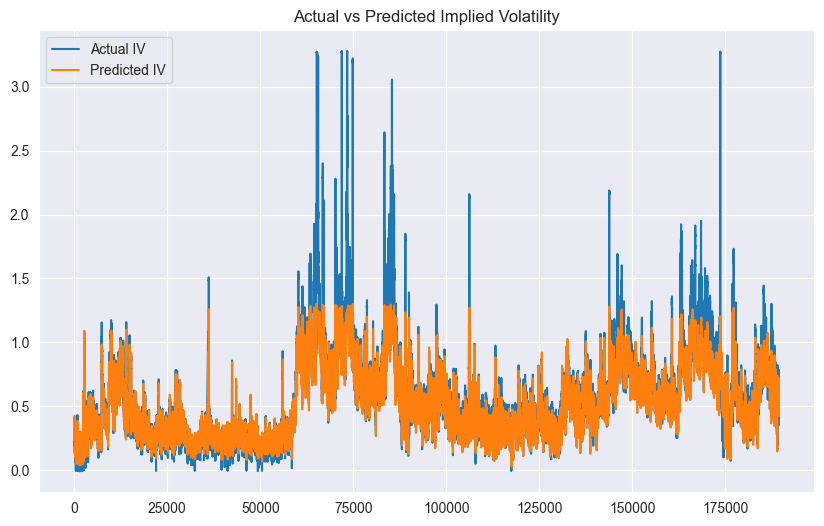

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(val_actual, label='Actual IV')
plt.plot(val_predictions, label='Predicted IV')
plt.legend()
plt.title('Actual vs Predicted Implied Volatility')
plt.show()

In [7]:
print("Generating test predictions...")
test_predictions = predict_test(models, test, scaler, feature_cols)
print(f"Test length: {len(test)}, Predictions length: {len(test_predictions)}")

submission = pd.DataFrame({
    'timestamp': test.index.values,
    'labels': test_predictions.flatten()
})
print("Submission DataFrame:\n", submission)
submission.to_csv('submissionETH1.csv', index=False)
print(f"Submission file created at 'submissionETH.csv' in {time.time() - start_time:.2f} seconds")

Generating test predictions...
Test feature columns: ['iv', 'mid_price', 'spread', 'volume_imbalance', 'price_velocity', 'iv_ema', 'hour', 'day_of_week', 'rsi', 'macd', 'macd_signal', 'bid_ask_ratio_2', 'bid_ask_ratio_3', 'bid_ask_ratio_4', 'bid_ask_ratio_5', 'iv_lag_1', 'iv_lag_5', 'iv_lag_10', 'price_velocity_lag_1', 'price_velocity_lag_5', 'price_velocity_lag_10', 'volume_imbalance_lag_1', 'volume_imbalance_lag_5', 'volume_imbalance_lag_10']
test_scaled shape: (270548, 24)


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



test_sequences shape: (270548, 90, 24)
Test length: 270548, Predictions length: 270548
Submission DataFrame:
         timestamp    labels
0               1  0.472623
1               2  0.472860
2               3  0.471673
3               4  0.468977
4               5  0.468208
...           ...       ...
270543     270544  0.124966
270544     270545  0.124966
270545     270546  0.124966
270546     270547  0.124966
270547     270548  0.124966

[270548 rows x 2 columns]
Submission file created at 'submissionETH.csv' in 805.25 seconds


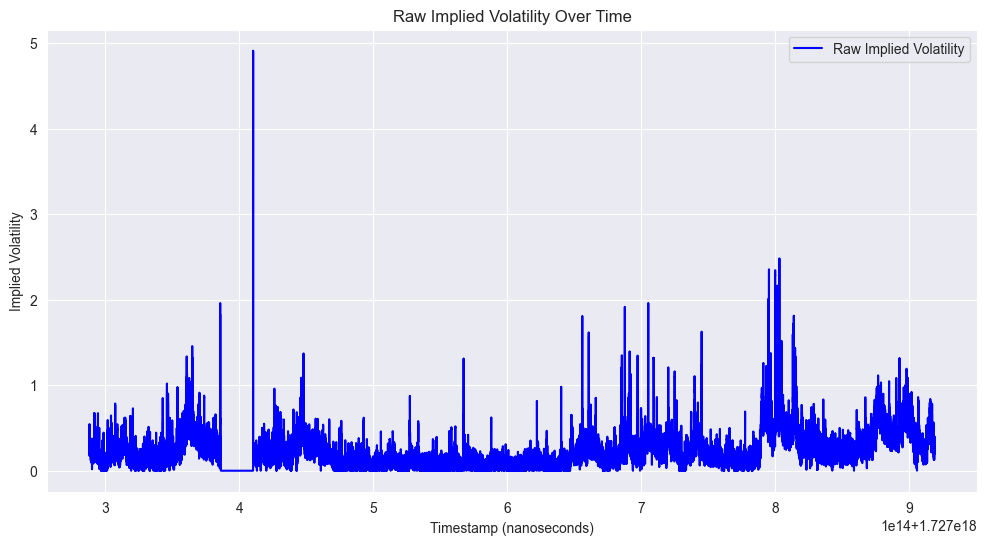

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['iv'], label='Raw Implied Volatility', color='blue')
plt.title('Raw Implied Volatility Over Time')
plt.xlabel('Timestamp (nanoseconds)')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()


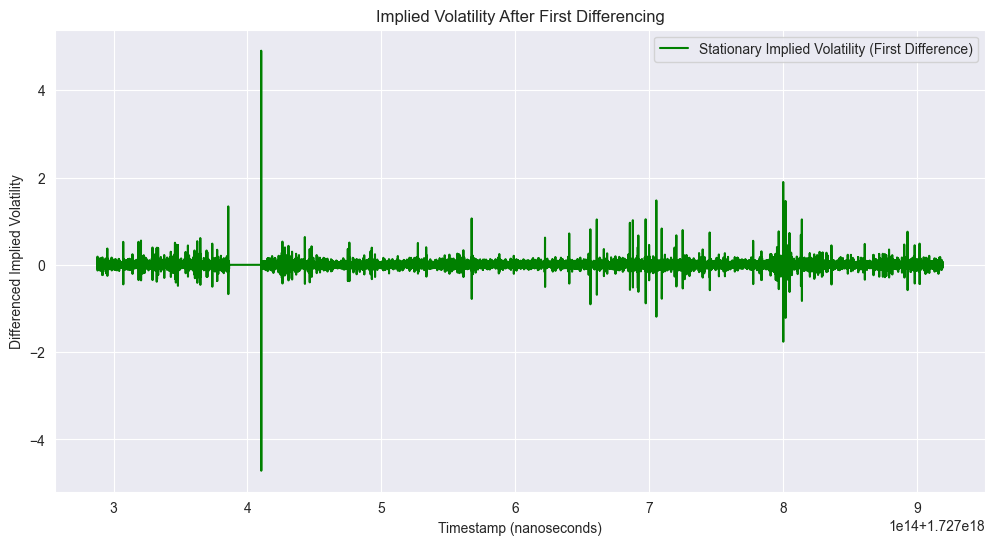

In [113]:
iv_diff = train['iv'].diff().dropna()  # Compute difference
# Create a new DataFrame with a unique index for iv_diff
train_with_diff = train.iloc[1:].copy()  # Shift to align with diff
train_with_diff['iv_diff'] = iv_diff.values  # Assign values directly
plt.figure(figsize=(12, 6))
plt.plot(train_with_diff.index, train_with_diff['iv_diff'], label='Stationary Implied Volatility (First Difference)', color='green')
plt.title('Implied Volatility After First Differencing')
plt.xlabel('Timestamp (nanoseconds)')
plt.ylabel('Differenced Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(train_with_diff['iv_diff'].dropna(), ax=plt.gca(), lags=40)
plt.title('ACF of Differenced IV')
plt.subplot(122)
plot_pacf(train_with_diff['iv_diff'].dropna(), ax=plt.gca(), lags=40)
plt.title('PACF of Differenced IV')
plt.tight_layout()
plt.show()

In [8]:
print("Initiating ARIMA training...")
if 'iv' not in train.columns:
    raise KeyError("'iv' column not found in training DataFrame")
train_subset = train['iv'].copy()  # Use full data
arima_fit, fitted_values, residuals = fit_arima(train_subset, order=(1, 1, 1))  # Initial order
train['residuals'] = 0.0
train.iloc[-len(residuals):, train.columns.get_loc('residuals')] = residuals.values
#print(f"ARIMA training finished in {time.time() - start_time:.2f} seconds")

# Calculate RMSE and MAPE on training data
actual_iv = train['iv'].iloc[len(train['iv']) - len(fitted_values):]  # Align with fitted values
rmse = np.sqrt(mean_squared_error(actual_iv, fitted_values))
mape = np.mean(np.abs((actual_iv - fitted_values) / np.maximum(np.abs(actual_iv), 1e-5))) * 100  # Robust MAPE
print(f"RMSE on training data: {rmse:.6f}")
print(f"MAPE on training data: {mape:.2f}%")

# Optional: Print ranges for debugging
print("Actual IV range:", actual_iv.min(), actual_iv.max())
print("Fitted IV range:", fitted_values.min(), fitted_values.max())

# Stationarity check
result = adfuller(train['iv'].diff().dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Generate test predictions using only ARIMA
start_time = time.time()
print("Generating test predictions...")
arima_forecasts = arima_fit.forecast(steps=len(test) + FORECAST_HORIZON)
arima_forecasts = np.array(arima_forecasts)  # Convert to NumPy array
test_predictions = arima_forecasts[FORECAST_HORIZON-1:len(test)+FORECAST_HORIZON-1]

# Create submission DataFrame
submission = pd.DataFrame({
    'timestamp': test.index.values,  # Use integer timestamp index
    'labels': test_predictions
})
submission['timestamp'] = pd.to_datetime(submission['timestamp'], unit='ns')  # Convert from nanoseconds
submission['timestamp'] = submission['timestamp'].astype(np.int64)  # Back to integer nanoseconds
submission.to_csv('submission.csv', index=False)
print(f"Submission file created at 'submission.csv' in {time.time() - start_time:.2f} seconds")

Initiating ARIMA training...


C:\Users\Asus\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Asus\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RMSE on training data: 0.017213
MAPE on training data: 278.83%
Actual IV range: 0.0 4.91062942454529
Fitted IV range: -0.00490356223057721 5.0373054116677
ADF Statistic: -124.23222227050462
p-value: 0.0
Generating test predictions...


C:\Users\Asus\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Asus\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Submission file created at 'submission.csv' in 3.38 seconds


In [75]:
submission['timestamp']=test['timestamp']

In [105]:
test=pd.read_csv('test/BTC.csv')

In [106]:
if 'timestamp' in test.columns:
    submission_timestamps = test['timestamp'].values
else:
    submission_timestamps = test.index.values  # Fallback to index
submission = pd.DataFrame({
    'timestamp': test['timestamp'],
    'labels': test_predictions
})
# Convert to datetime and back to int64 to ensure proper format
submission['timestamp'] = pd.to_datetime(submission['timestamp'])
submission['timestamp'] = submission['timestamp'].astype(np.int64)

# Debug: Print submission DataFrame
print("Submission DataFrame:\n", submission.head())

submission.to_csv('submission.csv', index=False)
print(f"Submission file created at 'submission.csv' in {time.time() - start_time:.2f} seconds")

Submission DataFrame:
    timestamp    labels
0          1  0.284591
1          2  0.284591
2          3  0.284591
3          4  0.284591
4          5  0.284591
Submission file created at 'submission.csv' in 7757.59 seconds


In [95]:
submission['timestamp']=test['timestamp']

In [96]:
submission[]

,timestamp,labels
0,NaT,0.284591
1,1970-01-01 00:00:00.000000001,0.284591
2,1970-01-01 00:00:00.000000002,0.284591
3,1970-01-01 00:00:00.000000003,0.284591
4,1970-01-01 00:00:00.000000004,0.284591
...,...,...
270543,1970-01-01 00:00:00.000270543,0.284591
270544,1970-01-01 00:00:00.000270544,0.284591
270545,1970-01-01 00:00:00.000270545,0.284591
270546,1970-01-01 00:00:00.000270546,0.284591
